# AI-Powered Algorithmic Trading with Python

### Case Study: AI-Powered Strategy

## Oanda API 

In [1]:
import tpqoa
import numpy as np
import pandas as pd

In [2]:
from pylab import plt
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = 'svg'

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
oanda = tpqoa.tpqoa('../oanda.cfg')

## The Data 

In [5]:
%%time
data = oanda.get_history(
    instrument='BCO_USD',
    start='2023-06-14',
    end='2023-06-15',
    granularity='S5',
    price='M'
)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11435 entries, 2023-06-14 00:00:00 to 2023-06-14 21:57:55
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         11435 non-null  float64
 1   h         11435 non-null  float64
 2   l         11435 non-null  float64
 3   c         11435 non-null  float64
 4   volume    11435 non-null  int64  
 5   complete  11435 non-null  bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 547.2 KB
CPU times: user 341 ms, sys: 15.4 ms, total: 356 ms
Wall time: 1.69 s


In [6]:
data['r'] = np.log(data['c'] / data['c'].shift(1))

In [7]:
data['d'] = np.sign(data['r'])

## The Strategy 

In [8]:
lags = 3

In [9]:
cols = list()
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['r'].shift(lag)
    cols.append(col)

In [10]:
data.head()

,o,h,l,c,volume,complete,r,d,lag_1,lag_2,lag_3
time,,,,,,,,,,,
2023-06-14 00:00:00,74.159,74.164,74.159,74.164,2,True,NaN,NaN,NaN,NaN,NaN
2023-06-14 00:00:05,74.169,74.169,74.139,74.139,8,True,-0.000337,-1.0,NaN,NaN,NaN
2023-06-14 00:00:10,74.159,74.159,74.134,74.134,3,True,-0.000067,-1.0,-0.000337,NaN,NaN
2023-06-14 00:00:15,74.114,74.134,74.114,74.129,7,True,-0.000067,-1.0,-0.000067,-0.000337,NaN
2023-06-14 00:00:25,74.124,74.124,74.114,74.114,2,True,-0.000202,-1.0,-0.000067,-0.000067,-0.000337


In [11]:
data.dropna(inplace=True)

In [12]:
data['d'] = data['d'].astype(int)

## Train-Test Split

In [13]:
split = int(len(data) * 0.8)
split

9144

In [14]:
train = data.iloc[:split].copy()

In [15]:
mu, std = train.mean(), train.std()

In [16]:
train_ = (train - mu) / std

In [17]:
test = data.iloc[split:].copy()

In [18]:
test_ = (test - mu) / std

## Training of the Model

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [20]:
model = MLPClassifier(hidden_layer_sizes=[24],
                      shuffle=False,
                      max_iter=500)

In [21]:
model.fit(train_[cols], train['d'])

MLPClassifier(hidden_layer_sizes=[24], max_iter=500, shuffle=False)

In [22]:
accuracy_score(train['d'], model.predict(train_[cols]))

0.43580489938757655

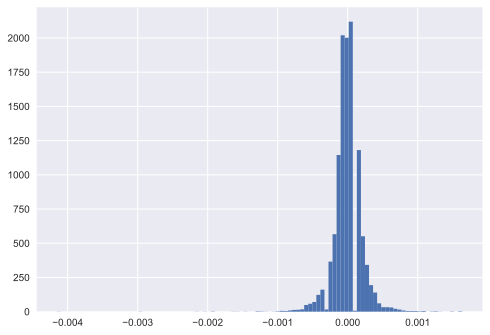

In [23]:
data['r'].hist(bins=100);

## Testing of the Model

In [24]:
test['p'] = model.predict(test_[cols])

In [25]:
accuracy_score(test['d'], test['p'])

0.4302579798863139

In [26]:
test['s'] = test['p'] * test['r']

In [27]:
test[['r', 's']].sum().apply(np.exp)

r    0.992232
s    1.006379
dtype: float64

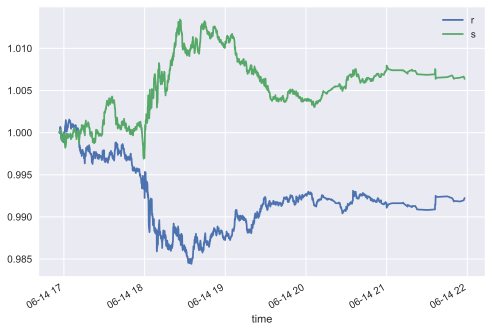

In [28]:
test[['r', 's']].cumsum().apply(np.exp).plot();

## Trading Code

In [29]:
oanda.on_success??

Signature: oanda.on_success(time, bid, ask)
Source:   
    def on_success(self, time, bid, ask):
        ''' Method called when new data is retrieved. '''
        print(time, bid, ask)
File:      ~/Python/envs/work/lib/python3.8/site-packages/tpqoa/tpqoa.py
Type:      method


In [30]:
oanda.stream_data('BCO_USD', stop=10)  # streaming data

2023-06-15T09:37:30.898327098Z 74.009 74.039
2023-06-15T09:37:45.026917617Z 74.014 74.044
2023-06-15T09:37:45.414371727Z 74.009 74.049
2023-06-15T09:37:45.640733375Z 74.004 74.034
2023-06-15T09:37:45.744644284Z 74.009 74.039
2023-06-15T09:37:46.854105015Z 74.004 74.034
2023-06-15T09:37:49.192007820Z 73.994 74.024
2023-06-15T09:37:49.445936122Z 73.989 74.019
2023-06-15T09:37:50.041196816Z 73.984 74.014
2023-06-15T09:37:50.446683952Z 73.989 74.019


In [31]:
oanda.create_order('BCO_USD', units=100)  # opening long position



 {'id': '3526', 'time': '2023-06-15T09:37:50.706973802Z', 'userID': 13834683, 'accountID': '101-004-13834683-001', 'batchID': '3525', 'requestID': '61118239246145035', 'type': 'ORDER_FILL', 'orderID': '3525', 'instrument': 'BCO_USD', 'units': '100.0', 'gainQuoteHomeConversionFactor': '0.917317013471', 'lossQuoteHomeConversionFactor': '0.926536279938', 'price': 74.024, 'fullVWAP': 74.024, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 73.994, 'liquidity': '5000'}, {'price': 73.984, 'liquidity': '5000'}, {'price': 73.974, 'liquidity': '10000'}], 'asks': [{'price': 74.024, 'liquidity': '5000'}, {'price': 74.034, 'liquidity': '5000'}, {'price': 74.044, 'liquidity': '10000'}], 'closeoutBid': 73.974, 'closeoutAsk': 74.044}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '101292.3298', 'tradeOpened': {'tradeID': '3526', 'units': '100.0', 'price': 74.024, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': 

In [32]:
oanda.create_order('BCO_USD', units=-100)  # closing long position



 {'id': '3528', 'time': '2023-06-15T09:37:50.852999858Z', 'userID': 13834683, 'accountID': '101-004-13834683-001', 'batchID': '3527', 'requestID': '61118239246145182', 'type': 'ORDER_FILL', 'orderID': '3527', 'instrument': 'BCO_USD', 'units': '-100.0', 'gainQuoteHomeConversionFactor': '0.917317013471', 'lossQuoteHomeConversionFactor': '0.926536279938', 'price': 74.009, 'fullVWAP': 74.009, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 74.009, 'liquidity': '5000'}, {'price': 73.999, 'liquidity': '5000'}, {'price': 73.989, 'liquidity': '10000'}], 'asks': [{'price': 74.039, 'liquidity': '4900'}, {'price': 74.049, 'liquidity': '5000'}, {'price': 74.059, 'liquidity': '10000'}], 'closeoutBid': 73.989, 'closeoutAsk': 74.059}, 'reason': 'MARKET_ORDER', 'pl': '-1.3898', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '101290.94', 'tradesClosed': [{'tradeID': '3526', 'units': '-100.0', 'price': 74.009, 'realizedPL': '-1.3898', 'financing': '0.0', 

## Simple Deployment

In [ ]:
model.predict(test[cols])[-1]

In [33]:
class MLPTrader(tpqoa.tpqoa):
    def __init__(self, config_file, model, lags):
        super().__init__(config_file)
        self.model = model
        self.min_length = lags
        self.position = 0
        self.units = 100
        self.tick_data = pd.DataFrame()
    def on_success(self, time, bid, ask):
        trade = False
        print(self.ticks, end=' ')
        df = pd.DataFrame({'b': bid, 'a': ask, 'm': (ask + bid) / 2},
                         index=[pd.Timestamp(time).tz_localize(tz=None)])
        self.tick_data = pd.concat((self.tick_data, df))
        # resampling the tick data to 5 second intervals
        self.data = self.tick_data.resample('5s', label='right').last().ffill()
        self.data['r'] = np.log(self.data['m'] / self.data['m'].shift(1))
        self.data.dropna(inplace=True)
        if len(self.data) > self.min_length:
            self.min_length += 1
            # checking for long signal
            prediction = self.model.predict(
                self.data['m'].iloc[-lags-1:-1].values.reshape(1, -1))
            print(prediction)
            if prediction == 1 and self.position in [0, -1]:
                o = oanda.create_order(self.stream_instrument,
                                   units=(1 - self.position) * self.units,
                                   suppress=True, ret=True)
                print('\n*** GOING LONG ***')
                self.print_transactions(tid=int(o['id']) - 1)
                self.position = 1
            # checking for short signal
            elif prediction == -1 and self.position in [0, 1]:
                o = oanda.create_order(self.stream_instrument,
                                   units=-(1 + self.position) * self.units,
                                   suppress=True, ret=True)
                print('\n*** GOING SHORT ***')
                self.print_transactions(tid=int(o['id']) - 1)
                self.position = -1    

In [34]:
mt = MLPTrader('../oanda.cfg', model, lags=lags)
mt.stream_data('BCO_USD', stop=150)

1 2 3 4 5 6 [-1]

*** GOING SHORT ***
3530 | 2023-06-15T09:39:20.41 | BCO_USD |   -100.0 |      0.0
7 8 9 [-1]
10 [-1]
11 [-1]
12 [-1]
13 [-1]
14 15 [-1]
16 [-1]
17 [-1]
18 19 20 [-1]
21 [-1]
22 23 24 [-1]
25 26 27 [-1]
28 29 [-1]
30 31 32 [-1]
33 [-1]
34 35 [-1]
36 37 [-1]
38 [-1]
39 [-1]
40 [-1]
41 [-1]
42 43 [-1]
44 45 46 47 [-1]
48 [-1]
49 50 [-1]
51 [-1]
52 53 54 [-1]
55 [-1]
56 [-1]
57 58 [-1]
59 60 61 62 [-1]
63 64 [-1]
65 [-1]
66 67 68 69 [-1]
70 71 72 73 [-1]
74 75 76 77 [-1]
78 79 80 81 [-1]
82 [-1]
83 84 85 86 [-1]
87 [-1]
88 [-1]
89 90 91 92 [-1]
93 [-1]
94 95 [-1]
96 97 98 99 [-1]
100 [-1]
101 102 103 [-1]
104 [-1]
105 106 107 108 109 110 [-1]
111 112 113 114 115 [-1]
116 117 118 [-1]
119 120 121 [-1]
122 123 124 125 126 127 128 [-1]
129 130 [-1]
131 132 133 134 135 [-1]
136 137 [-1]
138 [-1]
139 [-1]
140 141 [-1]
142 143 [-1]
144 145 146 147 [-1]
148 [-1]
149 150 

In [35]:
from pprint import pprint
o = mt.create_order('BCO_USD', units=-mt.position * mt.units,
                    suppress=True, ret=True)
print('\n*** POSITION CLOSED ***')
mt.print_transactions(tid=int(o['id']) - 1)
print('\n')
pprint(o)


*** POSITION CLOSED ***
3532 | 2023-06-15T09:44:34.11 | BCO_USD |    100.0 |      0.0


{'accountBalance': '101290.9375',
 'accountID': '101-004-13834683-001',
 'batchID': '3531',
 'commission': '0.0',
 'financing': '-0.0025',
 'fullPrice': {'asks': [{'liquidity': '5000', 'price': 74.004},
                        {'liquidity': '5000', 'price': 74.014},
                        {'liquidity': '10000', 'price': 74.024}],
               'bids': [{'liquidity': '5000', 'price': 73.974},
                        {'liquidity': '5000', 'price': 73.964},
                        {'liquidity': '10000', 'price': 73.954}],
               'closeoutAsk': 74.024,
               'closeoutBid': 73.954,
               'type': 'PRICE'},
 'fullVWAP': 74.004,
 'gainQuoteHomeConversionFactor': '0.917638490624',
 'guaranteedExecutionFee': '0.0',
 'halfSpreadCost': '1.3834',
 'id': '3532',
 'instrument': 'BCO_USD',
 'lossQuoteHomeConversionFactor': '0.926860988017',
 'orderID': '3531',
 'pl': '0.0',
 'price': 74

<img src='http://hilpisch.com/tpq_logo.png' width="350px" align="right">